# Almost Visual Inertial Odometry

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.models import MobileNetV2
from torch.utils.data import DataLoader
from tqdm import tqdm
from  matplotlib import pyplot as plt
from matplotlib.image import imread
import pandas as pd
import numpy as np

# Constants

In [2]:
SEED = 20197
BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
GAMMA = 0.1   # torch default
LR=0.001 
EPOCHS = 50

In [3]:
torch.manual_seed(SEED)
np.random.seed(SEED)

# Device

In [4]:
available_cuda = torch.cuda.is_available()
print(f"Available cuda: {available_cuda}")

device = torch.device("cuda" if available_cuda else "cpu")

Available cuda: True


# Dataset

In [5]:
class AdvioDataset(torch.utils.data.Dataset):
      def __init__(self, frames, inertials, labels, inertials_buffer):
            self.frames = frames
            self.inertials = inertials
            self.lables = labels
            self.inertials_buffer = inertials_buffer

      def __len__(self):
            return len(self.frames) - 1

      def __getitem__(self, index):

            # load sample of frames
            sample_frame = self.frames[index + 1] - self.frames[index]
            sample_frame = torch.moveaxis(sample_frame, -1, 0)

            # build buffer sample of inertials
            sample_inertials_buffer = self.inertials_buffer[index + 1]

            # load labels
            label_odometry = self.lables[index + 1]

            # load inertials
            label_inertial = self.inertials[index + 1]

            return sample_frame, sample_inertials_buffer, label_odometry, label_inertial


frames = torch.Tensor(np.load("./data/advio-01/iphone/frames.npy"))
inertials = torch.Tensor(np.load("./data/advio-01/iphone/inertials.npy"))
labels = torch.Tensor(np.load("./data/advio-01/iphone/labels.npy"))
buffer_inertials = torch.Tensor(np.load("./data/advio-01/iphone/inertial_buffer.npy"))

length = frames.shape[0]
train_split = 0.6
val_split = 0.2
test_split = 0.2
assert train_split + val_split + test_split == 1

train_data = AdvioDataset(
      frames[:round(train_split*length)],
      inertials[:round(train_split*length)], 
      labels[:round(train_split*length)], 
      buffer_inertials[:round(train_split*length)])

val_data = AdvioDataset(
      frames[round(train_split*length):-round(val_split*length)],
      inertials[round(train_split*length):-round(val_split*length)], 
      labels[round(train_split*length):-round(val_split*length)], 
      buffer_inertials[round(train_split*length):-round(val_split*length)])

test_data = AdvioDataset(
      frames[-round(val_split*length):],
      inertials[-round(val_split*length):], 
      labels[-round(val_split*length):], 
      buffer_inertials[-round(val_split*length):])

params = {'batch_size': BATCH_SIZE,
          'shuffle': True,
          'num_workers': 6,
          'drop_last':True}
train_loader = DataLoader(train_data, **params)
val_loader = DataLoader(val_data, **params)
test_loader = DataLoader(test_data, **params)

In [6]:
for idx, (sample, _, _, _) in enumerate(train_loader):
    print(sample.shape)

    break

torch.Size([50, 3, 224, 224])


# Model

In [7]:
class BaselineNet(nn.Module):
    def __init__(self):
        super(BaselineNet, self).__init__()
        
        self.conv2d_odometry = MobileNetV2(num_classes=3)

    def forward(self, x):
        x = self.conv2d_odometry(x)
        return x

In [8]:
class ConvNet1D(nn.Module):
  def __init__(self):
    super(ConvNet1D,self).__init__()
    self.distribution = [0, 0, 0, 1, 0, 0, 0, 0, 1, 0]

    self.conv1 = nn.Conv1d(3,3,3,2)
    torch.nn.init.kaiming_uniform_(self.conv1.weight)
    
    self.conv2 = nn.Conv1d(3,3,3,2)
    torch.nn.init.kaiming_uniform_(self.conv2.weight)
    
    self.conv3 = nn.Conv1d(3,3,3,2)
    torch.nn.init.kaiming_uniform_(self.conv3.weight)
    
    self.conv4 = nn.Conv1d(3,3,3,2)
    torch.nn.init.kaiming_uniform_(self.conv4.weight)
    
    self.conv5 = nn.Conv1d(3,3,3,2)
    torch.nn.init.kaiming_uniform_(self.conv5.weight)

    self.conv6 = nn.Conv1d(3,3,3,2)
    torch.nn.init.kaiming_uniform_(self.conv6.weight)

    self.fc1 = nn.Linear(3,3)

  def forward(self,x):
    # adding uncertanty
    random_weights = torch.randn(x.shape)*2 + 1
    x = x * random_weights

    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))
    x = x.reshape(-1,3)
    x = self.fc1(x)
    
    return x

In [9]:
class InertialNet(nn.Module):
    def __init__(self):
        super(InertialNet, self).__init__()
        
        self.conv2d_odometry = MobileNetV2(num_classes=3)
        self.conv2d_inertial = MobileNetV2(num_classes=3)
        self.conv1d_inertial = ConvNet1D()

    def forward(self, x):
        x_odometry = self.conv2d_odometry(x)
        x_inertial = self.conv2d_inertial(x)
        return x

# Training

In [10]:
def normalize(data):
  data = data - data.min()
  data = data / data.max()
  return data

In [11]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    history_loss = 0

    for batch_idx, (data, _, labels_odometry, _) in enumerate(train_loader):
        # data preparation
        data = normalize(data)
        labels_odometry = labels_odometry.mean(axis=1)
        data, labels_odometry = data.to(device), labels_odometry.to(device)

        #forward
        optimizer.zero_grad()
        output = model(data)

        # loss
        loss = torch.sqrt(F.mse_loss(output, labels_odometry))

        # backward
        loss.backward()
        optimizer.step()

        #stats
        history_loss += loss.item()

        if batch_idx%60==0:
            print(f"\t[# {batch_idx: 4}] train_loss: {loss.item():.6f}")

    return history_loss/len(train_loader) # average epoch loss


In [12]:
def validation(model, device, val_loader, epoch):
    model.train()
    history_loss=0

    for batch_idx, (data, _, labels_odometry, _) in enumerate(val_loader):
        # data preparation
        data = normalize(data)
        labels_odometry = labels_odometry.mean(axis=1)
        data, labels_odometry = data.to(device), labels_odometry.to(device)

        # forward
        output = model(data)

        # loss
        loss = torch.sqrt(F.mse_loss(output, labels_odometry))

        #stats
        history_loss += loss.item()            

    return history_loss/len(val_loader) # average epoch loss


In [13]:
model = BaselineNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)

h_loss_train = []
h_loss_val = []

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch {epoch}/{EPOCHS}")

    loss_train = train(model, device, train_loader, optimizer, epoch)
    loss_val = validation(model, device, val_loader, epoch)
    print(f"\tval_loss: {loss_val:.6f}")

    #populating the history of the loss
    h_loss_train.append(loss_train)
    h_loss_val.append(loss_val)

np.save(f"train_loss_{BATCH_SIZE}.npy", h_loss_train)
np.save(f"val_loss_{BATCH_SIZE}.npy", h_loss_val)


Epoch 1/15
	[#    0] train_loss: 0.144029


KeyboardInterrupt: 

# Plotting

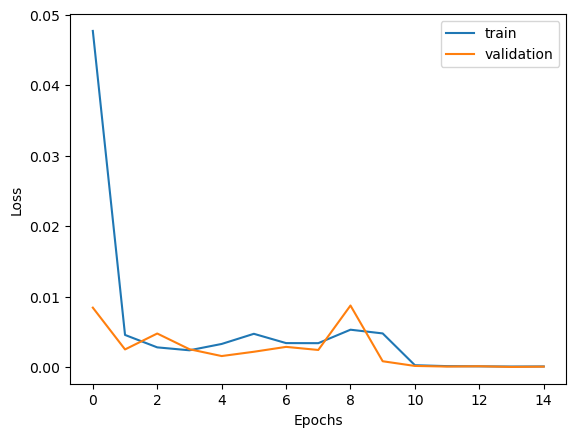

In [ ]:
plt.plot(h_loss_train, label="train")
plt.plot(h_loss_val, label="validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

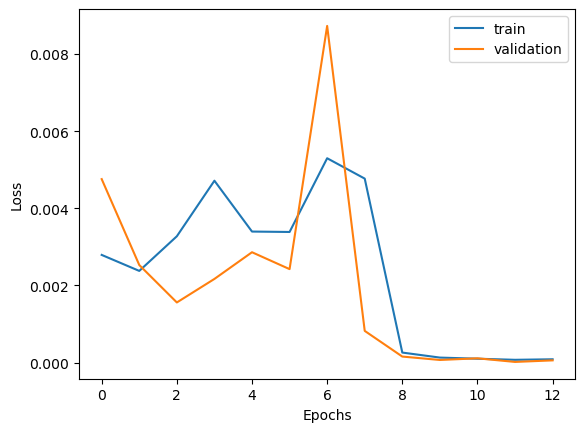

In [ ]:
plt.plot(np.array(h_loss_train)[2:], label="train")
plt.plot(np.array(h_loss_val)[2:], label="validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()